In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def rbf_kernel(x1, x2, sigma=1):
    y = x1.reshape(-1, 1)-x2.reshape(1,-1)
    return 2*np.exp(-0.5 / sigma**2 * np.square(y))

# Gaussian Process Regression class
class GaussianProcess:
    def __init__(self, kernel, noise=2e-2):
        self.kernel = kernel
        self.noise = noise


    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.K = self.kernel(X_train, X_train) + self.noise * np.eye(len(X_train))
        self.K_inv = np.linalg.inv(self.K)


    def predict(self, X_s):
        K_s = self.kernel(self.X_train, X_s)
        K_ss = self.kernel(X_s, X_s)

        mu_s = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov_s = K_ss - K_s.T.dot(self.K_inv).dot(K_s)
        return mu_s, cov_s
    

# class GaussianProcess:
#     def __init__(self, kernel, noise=1e-3):
#         self.kernel = kernel
#         self.noise = noise

#     def fit(self, X_train, y_train):
#         self.X_train = X_train
#         self.y_train = y_train
#         K = self.kernel(X_train, X_train) + self.noise * np.eye(len(X_train))
#         self.L = np.linalg.cholesky(K)

#     def predict(self, X_s):
#         K_s = self.kernel(self.X_train, X_s)
#         K_ss = self.kernel(X_s, X_s)

#         v = np.linalg.solve(self.L, self.y_train) # First solve L v = y
#         alpha = np.linalg.solve(self.L.T, v) # Then solve L^T alpha = v
#         mu_s = K_s.T.dot(alpha)

#         v = np.linalg.solve(self.L, K_s) # Solve for L\K_s
#         cov_s = K_ss - v.T.dot(v)

#         return mu_s, cov_s

In [83]:
# Training data (noisy observations)
# X_train = np.array([[-4], [-3], [-2], [-1], [1]]).astype(float)
# y_train = np.sin(X_train) + 0.1 * np.random.randn(*X_train.shape)
X_train = np.array(10*np.random.rand(10)).astype(float)
y_train = np.sin(2*X_train)+X_train/4 + 0.2 * np.random.randn(*X_train.shape)

# Test points
X_test = np.linspace(-1, 10, 100).reshape(-1, 1)

# Fit GP and predict
gp = GaussianProcess(rbf_kernel)
gp.fit(X_train, y_train)
mu_s, cov_s = gp.predict(X_test)
std_s = np.sqrt(np.diag(cov_s))

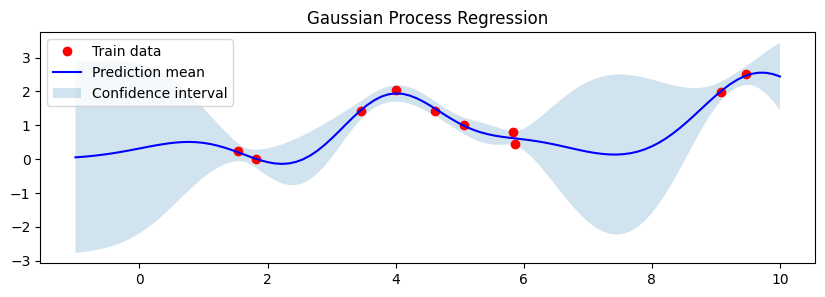

In [87]:
plt.figure(figsize=(10, 3))
plt.plot(X_train, y_train, 'ro', label='Train data')
plt.plot(X_test, mu_s, 'b', label='Prediction mean')
plt.fill_between(X_test.ravel(),
mu_s.ravel() - 2 * std_s,
mu_s.ravel() + 2 * std_s,
alpha=0.2, label='Confidence interval')
plt.legend(loc='upper left')
plt.title("Gaussian Process Regression")
plt.savefig("gaussian_result.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
def periodic_kernel(x1, x2, period=2*np.pi, l=1, sigma=1):
    y = x1.reshape(-1, 1) - x2.reshape(1, -1)
    return sigma**2*np.exp(-2 * np.sin(np.pi*y/period)**2/l**2)

In [6]:
X_test = np.linspace(-5, 10, 100).reshape(-1, 1)

# Fit GP and predict
gp = GaussianProcess(periodic_kernel, noise=0.05)
gp.fit(X_train, y_train)
mu_s, cov_s = gp.predict(X_test)
std_s = np.sqrt(np.diag(cov_s))

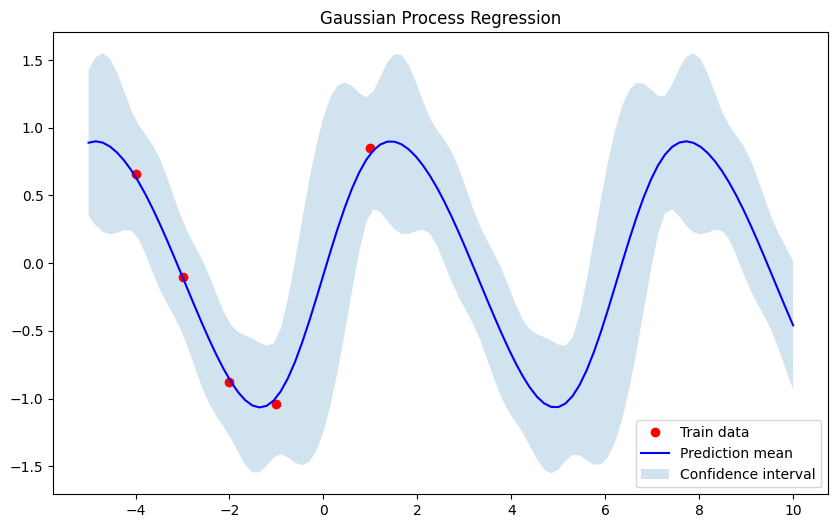

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Train data')
plt.plot(X_test, mu_s, 'b', label='Prediction mean')
plt.fill_between(X_test.ravel(),
mu_s.ravel() - 2 * std_s,
mu_s.ravel() + 2 * std_s,
alpha=0.2, label='Confidence interval')
plt.legend()
plt.title("Gaussian Process Regression")
plt.savefig("periodic_result.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def linear_kernel(x1, x2, c=0, sigma=1):
    return sigma**2*(x1.reshape(-1, 1)-c)*(x2.reshape(1, -1)-c)

In [51]:
X_train = np.array(-10 + 10*np.random.rand(10)).astype(float)
y_train = np.sin(X_train)+X_train/4 + 0.2 * np.random.randn(*X_train.shape)

# Test points
X_test = np.linspace(-12, 2, 100).reshape(-1, 1)

# Fit GP and predict
addition_kernel = lambda x1, x2: 10*linear_kernel(x1, x2) # + periodic_kernel(x1, x2) 
gp = GaussianProcess(addition_kernel, noise=0.01)
gp.fit(X_train, y_train)
mu_s, cov_s = gp.predict(X_test)
std_s = np.sqrt(np.diag(cov_s))

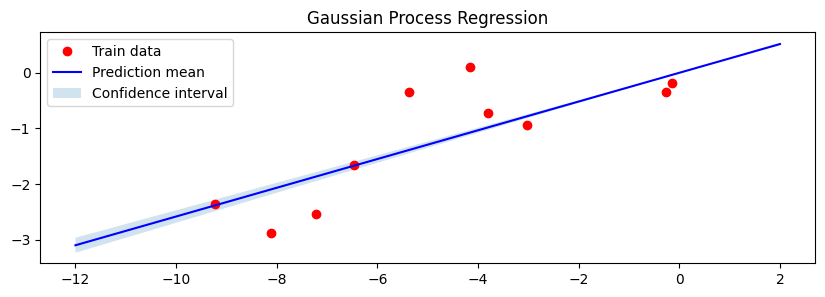

In [52]:
plt.figure(figsize=(10, 3))
plt.plot(X_train, y_train, 'ro', label='Train data')
plt.plot(X_test, mu_s, 'b', label='Prediction mean')
plt.fill_between(X_test.ravel(), mu_s.ravel() - 2 * std_s, mu_s.ravel() + 2 * std_s, alpha=0.2, label='Confidence interval')
plt.legend()
plt.title("Gaussian Process Regression")
plt.savefig("linear_periodic.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
from scipy.stats import norm

In [12]:
class GaussianProcessClassifier:
    def __init__(self, kernel, noise=1e-6):
        self.kernel = kernel
        self.noise = noise
    
    def fit(self, X_train, y_train, max_iter=100):
        self.X_train = X_train
        self.y_train = y_train.reshape(-1)
        self.K = self.kernel(X_train, X_train) + self.noise * np.eye(len(X_train))
        
        # Initialize latent function values
        f = np.zeros_like(self.y_train)
        
        # Newton-Raphson iteration for Laplace approximation
        for _ in range(max_iter):
            pi = 1 / (1 + np.exp(-f))  # logistic sigmoid
            W = np.diag(pi * (1 - pi))
            
            # Compute B inverse directly
            B = np.eye(len(X_train)) + np.sqrt(W) @ self.K @ np.sqrt(W)
            B_inv = np.linalg.inv(B)
            
            # Solve for b using inverse instead of Cholesky
            sqrt_W = np.sqrt(W)
            b = sqrt_W @ B_inv @ sqrt_W @ self.K @ (self.y_train - pi)
            
            f = self.K @ b  # update latent f
        
        self.f = f
        self.W = W
        self.pi = pi
        self.B_inv = B_inv  # store for prediction
    
    def predict_proba(self, X_s):
        K_s = self.kernel(self.X_train, X_s)
        K_ss = self.kernel(X_s, X_s)
        
        # Predictive mean and variance for latent function
        sqrt_W = np.sqrt(self.W)
        v = sqrt_W @ K_s
        f_mean = K_s.T.dot(self.y_train - self.pi)
        f_var = np.diag(K_ss - v.T @ self.B_inv @ v)
        
        # Approximate class probability via probit approximation
        probs = norm.cdf(f_mean / np.sqrt(1 + f_var))
        return probs
    
    def predict(self, X_s):
        probs = self.predict_proba(X_s)
        return (probs >= 0.5).astype(int)

In [13]:
np.random.seed(42)
X_train = -5+10*np.random.rand(15).reshape(-1, 1)
y_train = (np.sin(X_train) > 0).astype(int)  # binary labels (0/1)

X_test = np.linspace(-6, 10, 200).reshape(-1, 1)

gp_clf = GaussianProcessClassifier(rbf_kernel, noise=0.1)
gp_clf.fit(X_train, y_train)
probs = gp_clf.predict_proba(X_test)
preds = gp_clf.predict(X_test)

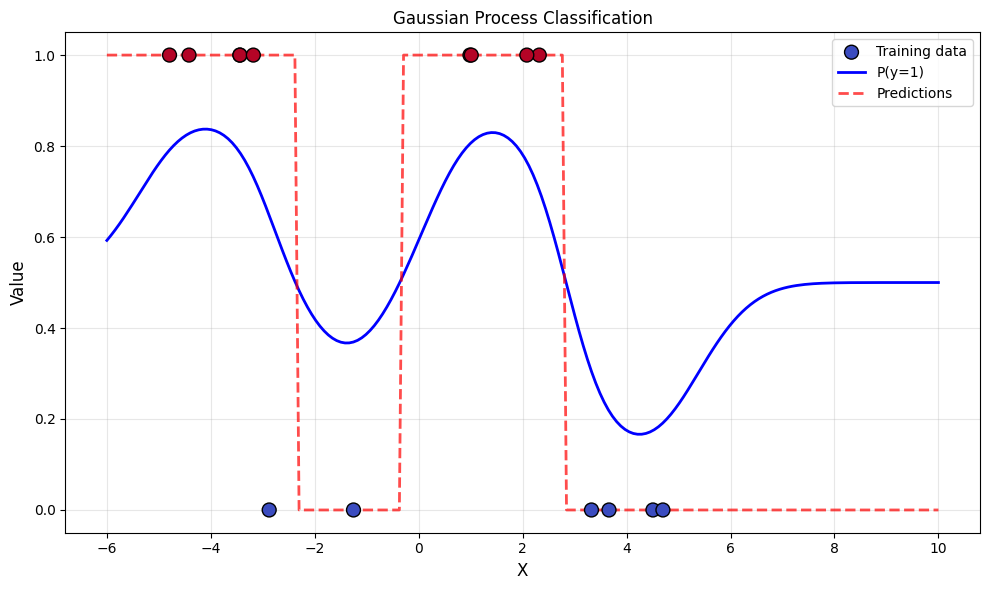

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c=y_train, cmap='coolwarm', s=100, edgecolors='k', label='Training data', zorder=3)
plt.plot(X_test, probs[:], 'b-', label='P(y=1)', linewidth=2)
plt.plot(X_test, preds, 'r--', label='Predictions', linewidth=2, alpha=0.7)
plt.xlabel('X', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.title('Gaussian Process Classification')
plt.tight_layout()
plt.savefig("GP_classification.png", dpi=300)
plt.show()